In [1]:
from cortexlib.images import CortexlabImages
from cortexlib.mouse import CortexlabMouse
from cortexlib.vgg19 import PreTrainedVGG19Model, PoolingMode
from cortexlib.tsne import TSNEVisualizer
from cortexlib.utils.random import GLOBAL_SEED
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from sklearn.preprocessing import StandardScaler
import torchvision.transforms.functional as TF
from sklearn.metrics import silhouette_score
from torch.utils.data import TensorDataset
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.manifold import TSNE
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch

logger = Logger()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

17:49:41 | INFO     | ℹ️ This notebook is running for mouse m03_d4


In [3]:
results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.012968,0.088767
9,conv3_4,100.0,0.012047,0.082980
10,conv4_4,NaN,0.011352,0.104368
15,conv5_4,NaN,0.008218,0.080550
20,fc2,NaN,0.006127,0.079454


In [4]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

17:49:41 | INFO     | ⏳ Computing null distributions for all neurons in mouse m03_d4...
17:50:06 | SUCCESS  | ✅ Null distributions computed!
17:50:07 | INFO     | ℹ️ Neural responses shape: (1573, 2, 500)


In [5]:
vgg19 = PreTrainedVGG19Model(pooling_mode=PoolingMode.AVGPOOL)

settings = vgg19.get_image_settings()
images = CortexlabImages(
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
    rescale_per_image=settings['rescale_per_image'],
)

logger.progress(f"Loading and preprocessing images shown to mouse {mouse.id}")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
17:50:08 | INFO     | ⏳ Loading and preprocessing images shown to mouse m03_d4...
17:50:23 | SUCCESS  | ✅ Images processed!


In [6]:
class_labels = images.load_class_labels(mouse.image_ids)

target_classes = ['bird', 'cat', 'rodent', 'insect', 'fungi', 'snake']
images_per_class = 78

# Group indices by class
class_to_indices = defaultdict(list)
for idx, label in enumerate(class_labels):
    if label in target_classes:
        class_to_indices[label].append(idx)

# Sample images_per_class per target class
sampled_indices = []
for cls in target_classes:
    if len(class_to_indices[cls]) < images_per_class:
        raise ValueError(f"Not enough images for class '{cls}'")
    sampled_indices.extend(random.sample(class_to_indices[cls], images_per_class))

In [7]:
logger.progress(f"VGG19: extracting features from {len(image_dataset)} images shown to mouse")
vgg19_feats, labels = vgg19.extract_features_with_pooling(image_dataset)
logger.success("VGG19 features extracted")

17:50:23 | INFO     | ⏳ VGG19: extracting features from 1573 images shown to mouse...


  0%|          | 0/99 [00:00<?, ?it/s]

17:54:07 | SUCCESS  | ✅ VGG19 features extracted!


In [8]:
# Filter features and labels to only include the sampled indices
subset_class_labels = [class_labels[i] for i in sampled_indices]
subset_neural_responses = neural_responses_mean[sampled_indices]
image_tensors, image_ids = image_dataset.tensors
subset_image_tensors = image_tensors[sampled_indices]
subset_image_ids = image_ids[sampled_indices]
subset_image_dataset = TensorDataset(subset_image_tensors, subset_image_ids)
subset_vgg19_feats = {layer: feats[sampled_indices] for layer, feats in vgg19_feats.items()}

In [9]:
tsne_visualiser = TSNEVisualizer()
layerwise_tsne_feats = {}
semanticity_results = []

logger.progress("Computing TSNE features from VGG19 features")
for n_pcs in [10, 20, 50, 100]:
    logger.info(f"{n_pcs} PCs")

    tsne_feats = tsne_visualiser.compute_tsne(subset_vgg19_feats, n_pca_components=n_pcs)
    silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, subset_class_labels)

    if n_pcs == 100:
        for layer, layer_tsne_feats in tsne_feats.items():
            layerwise_tsne_feats[layer] = layer_tsne_feats

    for layer, score in silhouette_scores.items():
        semanticity_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'silhouette_score': float(score) # json.dump() cannot serialize NumPy float32 types; convert to native Python floats first
        })

logger.success("TSNE features computed")

17:54:08 | INFO     | ⏳ Computing TSNE features from VGG19 features...
17:54:08 | INFO     | ℹ️ 10 PCs
17:54:14 | INFO     | ℹ️ 20 PCs
17:54:21 | INFO     | ℹ️ 50 PCs
17:54:28 | INFO     | ℹ️ 100 PCs
17:54:35 | SUCCESS  | ✅ TSNE features computed!


In [10]:
semanticity_results_df = pd.DataFrame(semanticity_results)
semanticity_results_df.head(12)

,layer,n_pcs,silhouette_score
0,conv2_2,10,-0.117758
1,conv3_4,10,-0.135377
2,conv4_4,10,-0.104037
3,conv5_4,10,-0.124622
4,fc2,10,-0.107910
5,conv2_2,20,-0.120849
6,conv3_4,20,-0.132695
7,conv4_4,20,-0.117252
8,conv5_4,20,-0.111473
9,fc2,20,-0.108885


In [11]:
futils.write_json_file(semanticity_results, './semanticity_stringer.json')

In [12]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
semanticity_pcs = semanticity_results_df[semanticity_results_df['n_pcs'] == 100].reset_index(drop=True)
semanticity_pcs

,layer,n_pcs,silhouette_score
0,conv2_2,100,-0.118599
1,conv3_4,100,-0.130327
2,conv4_4,100,-0.118461
3,conv5_4,100,-0.127971
4,fc2,100,-0.111466


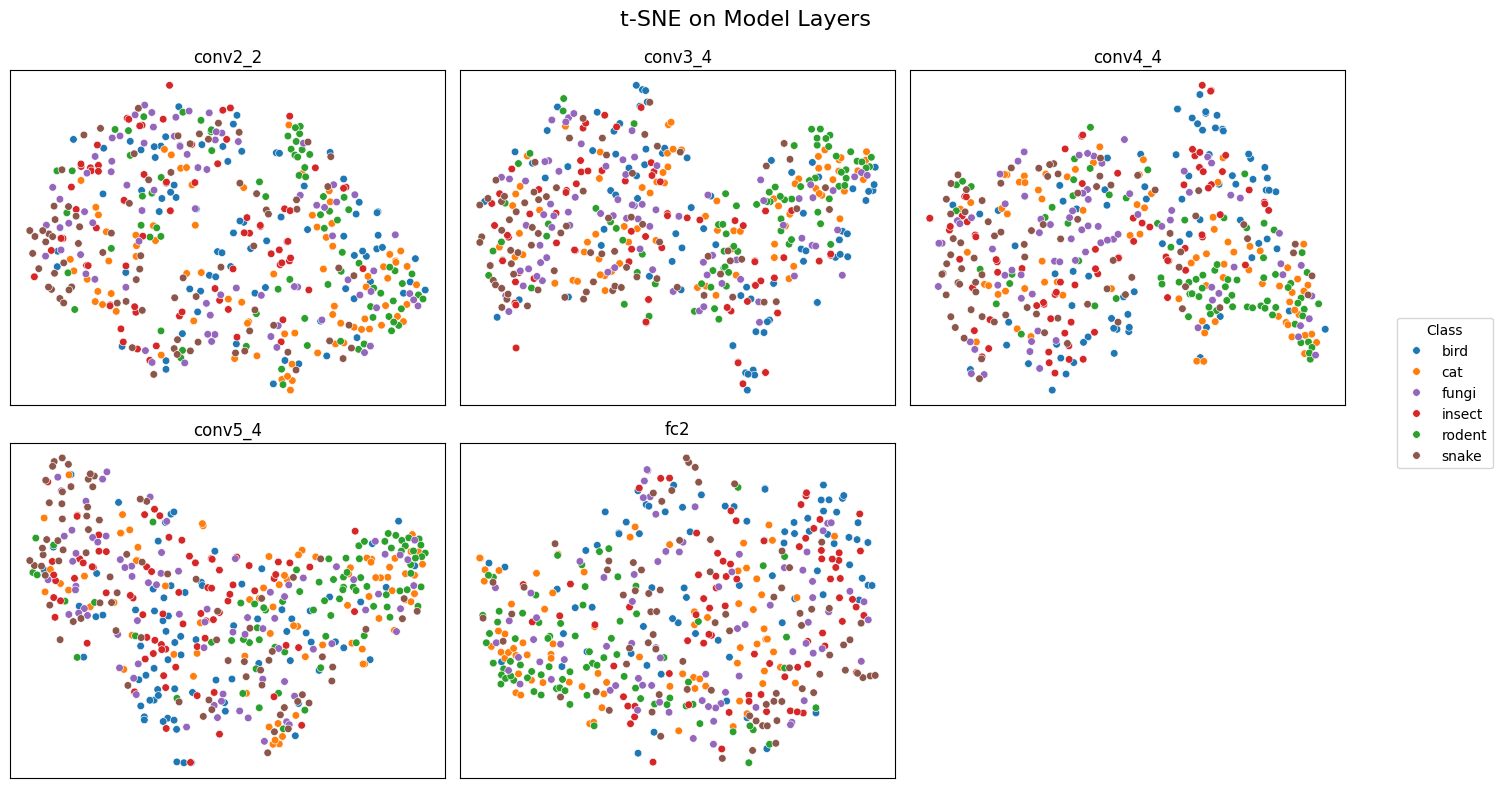

In [13]:
tsne_visualiser.plot_clusters_all_layers(tsne_feats, subset_class_labels)

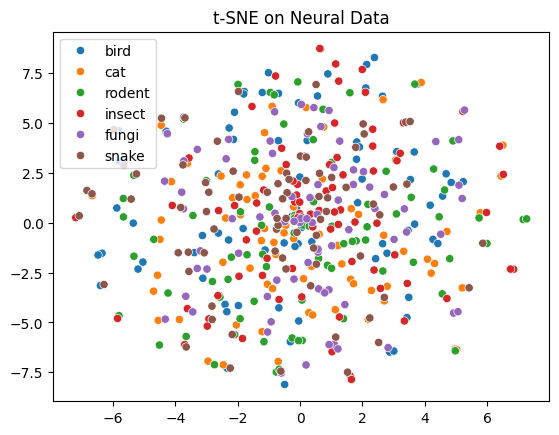

Silhouette score (neural): -0.071709596


In [14]:
X = StandardScaler().fit_transform(subset_neural_responses)
neural_feats_pca = PCA(n_components=100,
                            random_state=GLOBAL_SEED).fit_transform(X)
neural_tsne = TSNE(n_components=2, perplexity=30, random_state=GLOBAL_SEED)
neural_tsne_feats = neural_tsne.fit_transform(neural_feats_pca)

sns.scatterplot(x=neural_tsne_feats[:, 0], y=neural_tsne_feats[:, 1], hue=subset_class_labels, palette='tab10')
plt.title("t-SNE on Neural Data")
plt.show()

score = silhouette_score(neural_tsne_feats, subset_class_labels)
print("Silhouette score (neural):", score)

In [16]:
def mean_luminance(img_tensor):
    return img_tensor.mean().item()

def contrast(img_tensor):
    return img_tensor.std().item()

def edge_density(img_tensor):
    gray = TF.rgb_to_grayscale(img_tensor)
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).view(1, 1, 3, 3).float()
    sobel_y = sobel_x.transpose(2, 3)
    gx = F.conv2d(gray.unsqueeze(0), sobel_x, padding=1)
    gy = F.conv2d(gray.unsqueeze(0), sobel_y, padding=1)
    grad_mag = torch.sqrt(gx**2 + gy**2)
    return grad_mag.mean().item()

def spatial_freq(img_tensor):
    gray = TF.rgb_to_grayscale(img_tensor).squeeze()
    fft = torch.fft.fft2(gray)
    magnitude = torch.abs(fft)
    return magnitude.mean().item()

def compute_metrics(image_dataset, metric_fns):
    records = []
    for img_tensor, _ in image_dataset:
        img_tensor = img_tensor.detach().cpu()
        record = {name: fn(img_tensor) for name, fn in metric_fns.items()}
        records.append(record)
    return pd.DataFrame(records)

def bin_and_score(tsne_coords, df_metrics, n_bins=5, method="quantile"):
    results = []

    for metric in df_metrics.columns:
        if method == "quantile":
            labels = pd.qcut(df_metrics[metric], q=n_bins, labels=False, duplicates="drop")
        else:
            labels = pd.cut(df_metrics[metric], bins=n_bins, labels=False)
        
        if len(np.unique(labels)) < 2:
            sil_score = np.nan
        else:
            sil_score = silhouette_score(tsne_coords, labels)
        
        results.append({
            "metric": metric,
            "silhouette_score": sil_score
        })

    return pd.DataFrame(results)

def plot_tsne(tsne_coords, labels, label_name, layer):
    df_plot = pd.DataFrame(tsne_coords, columns=["x", "y"])
    df_plot[label_name] = labels
    fig = px.scatter(df_plot, x="x", y="y", color=df_plot[label_name].astype(str),
                     title=f"[{layer}] t-SNE colored by {label_name}", width=600, height=500)
    fig.show()

metric_fns = {
    "mean_luminance": mean_luminance,
    "contrast": contrast,
    "edge_density": edge_density,
    "spatial_freq": spatial_freq
}

df_metrics = compute_metrics(subset_image_dataset, metric_fns)

# Compute for neural data
scores_df = bin_and_score(neural_tsne_feats, df_metrics, n_bins=5, method="quantile")
print(scores_df)
for metric in df_metrics.columns:
    labels = pd.qcut(df_metrics[metric], q=5, labels=[f"bin{i}" for i in range(5)], duplicates="drop")
    plot_tsne(neural_tsne_feats, labels, label_name=metric, layer='neural')

from sklearn.linear_model import LinearRegression
r2 = LinearRegression().fit(df_metrics[["edge_density"]], neural_tsne_feats).score(df_metrics[["edge_density"]], neural_tsne_feats)
print(f"Neural: R² from edge_density to t-SNE: {r2:.3f}")

# Compute for model layers
for layer, tsne_feats in layerwise_tsne_feats.items():
    scores_df = bin_and_score(tsne_feats, df_metrics, n_bins=5, method="quantile")
    print(scores_df)

    for metric in df_metrics.columns:
        labels = pd.qcut(df_metrics[metric], q=5, labels=[f"bin{i}" for i in range(5)], duplicates="drop")
        plot_tsne(tsne_feats, labels, label_name=metric, layer=layer)

    r2 = LinearRegression().fit(df_metrics[["edge_density"]], tsne_feats).score(df_metrics[["edge_density"]], tsne_feats)
    print(f"{layer}: R² from edge_density to t-SNE: {r2:.3f}")

           metric  silhouette_score
0  mean_luminance         -0.060835
1        contrast         -0.064832
2    edge_density         -0.062784
3    spatial_freq         -0.056145


Neural: R² from edge_density to t-SNE: 0.018
           metric  silhouette_score
0  mean_luminance         -0.093919
1        contrast         -0.087698
2    edge_density          0.108097
3    spatial_freq          0.129241


conv2_2: R² from edge_density to t-SNE: 0.372
           metric  silhouette_score
0  mean_luminance         -0.106103
1        contrast         -0.102256
2    edge_density          0.315206
3    spatial_freq          0.041727


conv3_4: R² from edge_density to t-SNE: 0.455
           metric  silhouette_score
0  mean_luminance         -0.093509
1        contrast         -0.096655
2    edge_density          0.173540
3    spatial_freq          0.082546


conv4_4: R² from edge_density to t-SNE: 0.421
           metric  silhouette_score
0  mean_luminance         -0.078442
1        contrast         -0.070255
2    edge_density          0.008474
3    spatial_freq          0.040802


conv5_4: R² from edge_density to t-SNE: 0.314
           metric  silhouette_score
0  mean_luminance         -0.063198
1        contrast         -0.058304
2    edge_density         -0.011672
3    spatial_freq          0.019809


fc2: R² from edge_density to t-SNE: 0.204
